In [6]:
import numpy as np

In [22]:
import os
import pandas as pd

# Set the directory where your files are stored
directory = './yahoo_/yahoo_preprocessed/'  # Replace with the path to your files

# Initialize an empty list to store the individual DataFrames
data_frames = []

# Loop through all the files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):  # Assuming the files are in CSV format
        # Construct the full file path
        file_path = os.path.join(directory, filename)
        
        # Read the file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Extract the ticker symbol from the filename (assuming it's the first part of the file name before an underscore)
        ticker = filename.split('_')[0]
        
        # Add the 'Ticker' column to the DataFrame
        df['Ticker'] = ticker
        
        # Append the DataFrame to the list
        data_frames.append(df)

# Concatenate all the DataFrames in the list into a single DataFrame
combined_df = pd.concat(data_frames, ignore_index=True)

# Save the combined DataFrame to a new CSV file (optional)
combined_df.to_csv('./yahoo_/combined_data/combined_stock_data.csv', index=False)

# Now combined_df is your consolidated DataFrame with all the stock data


In [24]:
combined_df.columns


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'MA_5',
       'MA_10', 'MA_12', 'MA_26', 'MA_20', 'MA_50', 'MA_100', 'Pct_change',
       'Volatility', 'Day_of_week', 'RSI', 'MACD', 'MACD_signal',
       'Bollinger_mavg', 'Bollinger_hband', 'Bollinger_lband', 'Lag_1',
       'Lag_2', 'Lag_3', 'Volume_MA_10', 'Volume_pct_MA', 'High_Low_Range',
       'Price_Change_Direction', 'MACD_Hist', 'PPO', 'P/E_Ratio',
       'Volume_Norm', 'VIX', 'Ticker'],
      dtype='object')

Step 1: Handle Missing Values

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load your data into a pandas DataFrame
df = pd.read_csv('./yahoo_/combined_data/combined_stock_data.csv')

# Assuming 'Close' is what we want to predict and 'Date' is not a feature
features = df.drop(['Date', 'Close', 'Adj Close'], axis=1)

# Handle missing values
features.fillna(features.mean(), inplace=True)

# Split features into numeric and categorical
numeric_features = features.select_dtypes(include=['int64', 'float64']).columns
categorical_features = ['Day_of_week']  # Add other categorical features if needed

# Create the preprocessing pipelines for both numeric and categorical data
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Now, we fit the preprocessor to the features to later retrieve the feature names
preprocessor.fit(features)

# Transform the features using the fitted ColumnTransformer
X_transformed = preprocessor.transform(features)

# Apply SelectKBest to the transformed features
selector = SelectKBest(score_func=f_classif, k='all')
X_selected = selector.fit_transform(X_transformed, df['Close'])

# Get the support mask from SelectKBest and apply it to the feature names outputted by the ColumnTransformer
selected_mask = selector.get_support()

# Feature names after one-hot encoding
onehot_columns = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
# All feature names
all_feature_names = np.array(list(numeric_features) + list(onehot_columns))

# The selected feature names
selected_features = all_feature_names[selected_mask]

# Now let's perform the train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y_binary, test_size=0.2, random_state=42)

# Save the data to the specified directory
save_dir = './yahoo_/combined_data/'

# Save the split data
pd.DataFrame(X_train).to_csv(f"{save_dir}X_train.csv", index=False)
pd.Series(y_train).to_csv(f"{save_dir}y_train.csv", index=False)
pd.DataFrame(X_test).to_csv(f"{save_dir}X_test.csv", index=False)
pd.Series(y_test).to_csv(f"{save_dir}y_test.csv", index=False)

# Output the paths to the saved files
file_paths = {
    'X_train': f"{save_dir}X_train.csv",
    'y_train': f"{save_dir}y_train.csv",
    'X_test': f"{save_dir}X_test.csv",
    'y_test': f"{save_dir}y_test.csv"
}
file_paths

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Load your dataset (assuming it's already loaded as df)
df = pd.read_csv('./yahoo_/combined_data/combined_stock_data.csv')

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort the DataFrame by date
df = df.sort_values(by='Date')

# Set the 'Date' column as the index
df.set_index('Date', inplace=True)

# Check for missing values and handle them if necessary
print(df.isnull().sum())

# Seasonal Decomposition of Time Series
decomposed = seasonal_decompose(df['Close*'], model='additive', period=1)  # Assuming daily data with no strong seasonality

# Check for duplicate dates
duplicate_dates = df.index.duplicated()
if duplicate_dates.any():
    print("Duplicate dates found. Handling duplicates...")
    # This is an example of handling duplicates by keeping the first occurrence
    df = df[~duplicate_dates]

# Now you can safely perform the differencing operation
df['Close*_diff'] = df['Close*'].diff().dropna()

# After differencing, you can run the ADF test again
from statsmodels.tsa.stattools import adfuller

adf_result_diff = adfuller(df['Close*_diff'].dropna())
print(f'ADF Statistic (after differencing): {adf_result_diff[0]}')
print(f'p-value (after differencing): {adf_result_diff[1]}')


# Stationarity Check using Augmented Dickey-Fuller test
adf_result = adfuller(df['Close*'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

# If the p-value is greater than 0.05, we'll need to difference the data
if adf_result[1] > 0.05:
    df['Close*_diff'] = df['Close*'].diff().dropna()
    adf_result_diff = adfuller(df['Close*_diff'].dropna())
    print(f'ADF Statistic (after differencing): {adf_result_diff[0]}')
    print(f'p-value (after differencing): {adf_result_diff[1]}')

    
    
# From here, we would proceed with time-series modeling such as ARIMA.


Open                      0
High                      0
Low                       0
Close                     0
Adj Close                 0
Volume                    0
MA_5                      0
MA_10                     0
MA_12                     0
MA_26                     0
MA_20                     0
MA_50                     0
MA_100                    0
Pct_change                0
Volatility                0
Day_of_week               0
RSI                       0
MACD                      0
MACD_signal               0
Bollinger_mavg            0
Bollinger_hband           0
Bollinger_lband           0
Lag_1                     0
Lag_2                     0
Lag_3                     0
Volume_MA_10              0
Volume_pct_MA             0
High_Low_Range            0
Price_Change_Direction    0
MACD_Hist                 0
PPO                       0
P/E_Ratio                 0
Volume_Norm               0
VIX                       0
Ticker                    0
dtype: int64


KeyError: 'Close*'

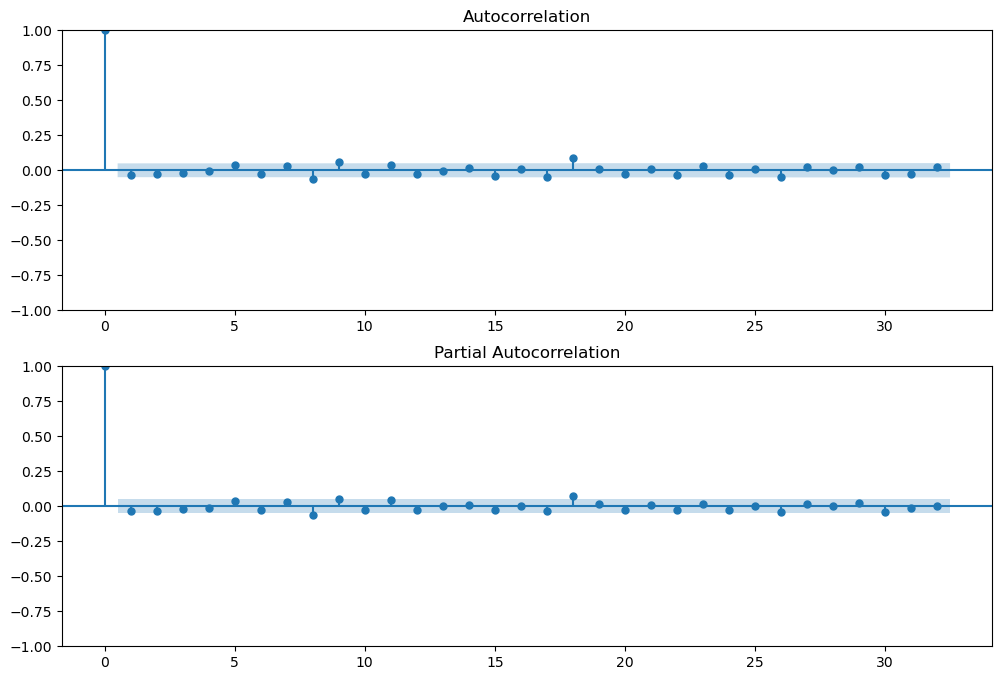

                               SARIMAX Results                                
Dep. Variable:                 Close*   No. Observations:                 1631
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -3430.095
Date:                Sun, 05 Nov 2023   AIC                           6870.189
Time:                        14:09:46   BIC                           6897.162
Sample:                    08-04-2017   HQIC                          6880.196
                         - 11-03-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5102      0.002    290.481      0.000       0.507       0.514
ar.L2         -1.0012      0.002   -553.971      0.000      -1.005      -0.998
ma.L1         -0.5159      0.418     -1.236      0.2

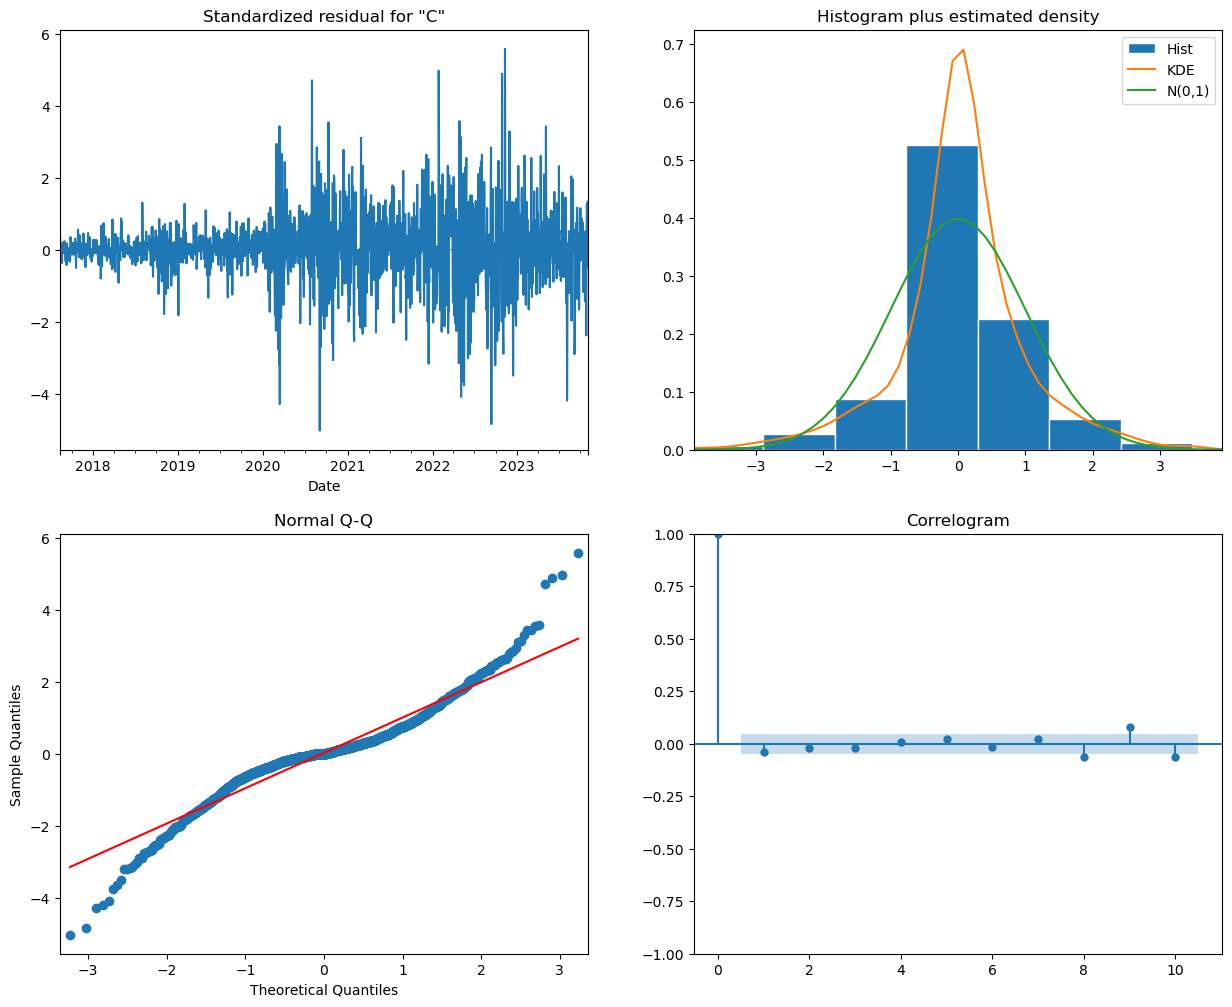

count    1574.000000
mean        0.117523
std         2.405751
min       -10.612563
25%        -0.774117
50%         0.073643
75%         0.973885
max        39.100000
dtype: float64


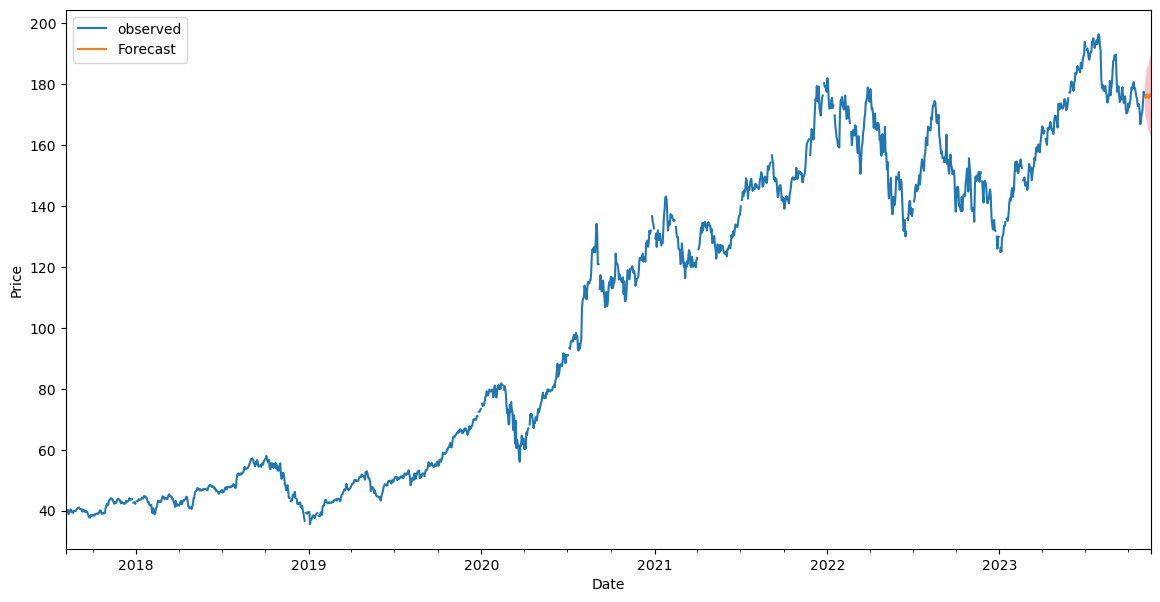

In [5]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Ensure the frequency of the index
df = df.asfreq('B')  # 'B' stands for business day frequency

# If there are missing dates or NaN values, you might need to handle them
# df = df.interpolate()  # Example to interpolate missing values

# Plot ACF and PACF to identify potential AR and MA orders
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['Close*_diff'].dropna(), ax=ax1)  # ACF plot
plot_pacf(df['Close*_diff'].dropna(), ax=ax2)  # PACF plot
plt.show()

# Based on the plots, identify the orders p (AR) and q (MA)
p = 2  # Replace with identified value from PACF plot
d = 1  # Differencing order from ADF test
q = 2  # Replace with identified value from ACF plot

# Fit the ARIMA model with method_kwargs
model = ARIMA(df['Close*'], order=(p, d, q), enforce_stationarity=False, enforce_invertibility=False)
results = model.fit(method_kwargs={"maxiter": 1000})  # specify maxiter in method_kwargs

# Check the model summary
print(results.summary())

# Diagnostics plots
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Descriptive statistics of the residuals
print(results.resid.describe())


# Forecast with confidence intervals
n_forecast = 10  # example forecast next 10 data points
forecast_result = results.get_forecast(steps=n_forecast)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(alpha=0.05)

# Plot the forecast along with the confidence band
ax = df['Close*'].plot(label='observed', figsize=(14, 7))
forecast.plot(ax=ax, label='Forecast')
ax.fill_between(forecast.index,
                conf_int.iloc[:, 0],
                conf_int.iloc[:, 1], color='pink')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.legend()
plt.show()


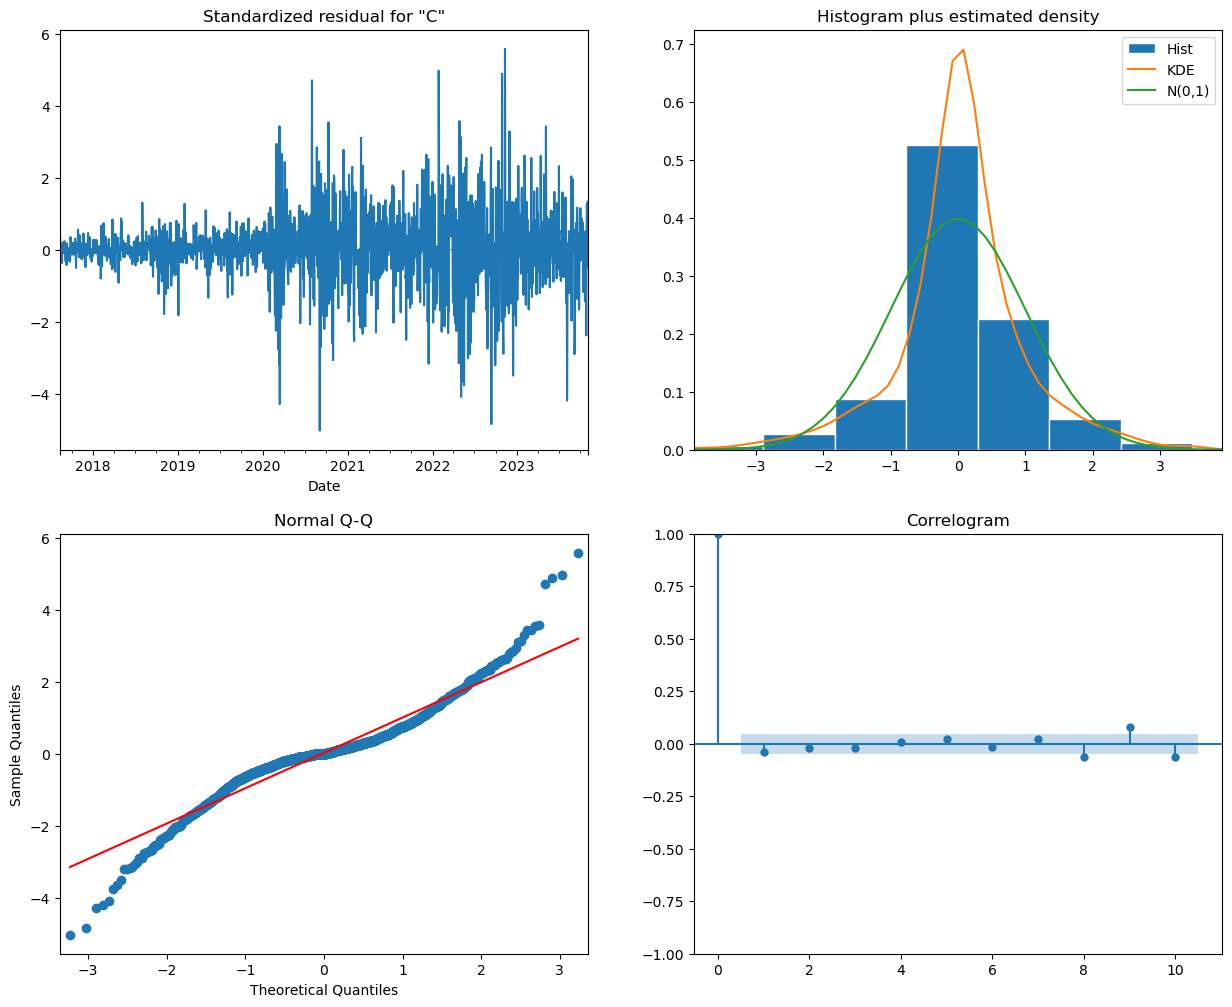

count    1574.000000
mean        0.117523
std         2.405751
min       -10.612563
25%        -0.774117
50%         0.073643
75%         0.973885
max        39.100000
dtype: float64


In [7]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

# Descriptive statistics of the residuals
print(results.resid.describe())


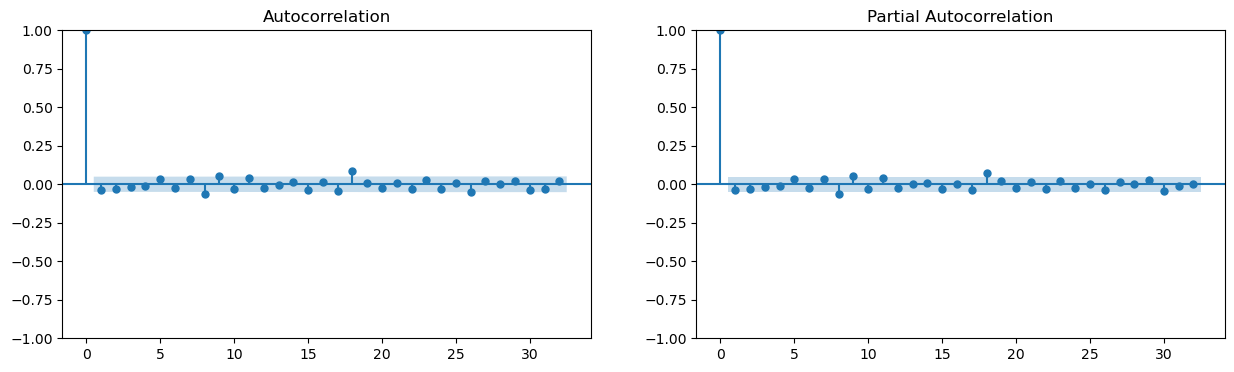

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(df['Close*_diff'].dropna(), ax=axes[0])
plot_pacf(df['Close*_diff'].dropna(), ax=axes[1])
plt.show()

In [8]:
# Trying different orders for ARIMA and comparing AIC/BIC
import itertools

p = d = q = range(0, 3)  # Example range, could be adjusted
pdq = list(itertools.product(p, d, q))

for param in pdq:
    try:
        mod = ARIMA(df['Close*'], order=param)
        results = mod.fit()
        print('ARIMA{} - AIC:{} - BIC:{}'.format(param, results.aic, results.bic))
    except:
        continue


ARIMA(0, 0, 0) - AIC:16855.118756479584 - BIC:16865.912653684827
ARIMA(0, 0, 1) - AIC:14926.933359166891 - BIC:14943.124204974754
ARIMA(0, 0, 2) - AIC:13234.973529020954 - BIC:13256.561323431437
ARIMA(0, 1, 0) - AIC:6887.839923426016 - BIC:6893.236258719817
ARIMA(0, 1, 1) - AIC:6886.687255746798 - BIC:6897.479926334399
ARIMA(0, 1, 2) - AIC:6886.83319775913 - BIC:6903.022203640532
ARIMA(0, 2, 0) - AIC:8067.912328272061 - BIC:8073.308049880663
ARIMA(0, 2, 1) - AIC:6891.426812297681 - BIC:6902.218255514885
ARIMA(0, 2, 2) - AIC:6890.016330132309 - BIC:6906.203494958116
ARIMA(1, 0, 0) - AIC:6902.567998870525 - BIC:6918.758844678388
ARIMA(1, 0, 1) - AIC:6901.474655041148 - BIC:6923.062449451632
ARIMA(1, 0, 2) - AIC:6901.668395271925 - BIC:6928.65313828503
ARIMA(1, 1, 0) - AIC:6886.909810119395 - BIC:6897.7024807069965
ARIMA(1, 1, 1) - AIC:6887.24753340692 - BIC:6903.436539288323
ARIMA(1, 1, 2) - AIC:6888.754927378442 - BIC:6910.340268553645
ARIMA(1, 2, 0) - AIC:7598.008940447358 - BIC:7608.8

/Users/ruthikkale/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


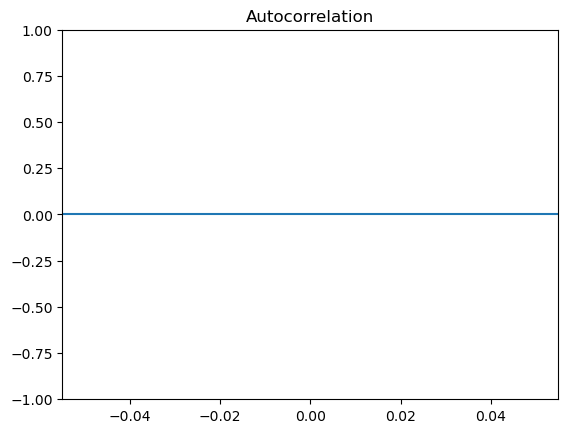

count    1574.000000
mean        0.032855
std         2.409933
min       -18.949998
25%        -0.811727
50%         0.035298
75%         0.914432
max        39.100000
dtype: float64


In [9]:
# Recheck residuals
residuals = results.resid
plot_acf(residuals)
plt.show()

# Check mean and variance of residuals
print(residuals.describe())


In [10]:
# Final model forecast
forecast = results.get_forecast(steps=5)
forecast_summary = forecast.summary_frame()
print(forecast_summary)


Close*            mean   mean_se  mean_ci_lower  mean_ci_upper
2023-11-06  176.737035  2.123099     172.575836     180.898233
2023-11-07  176.887301  2.947404     171.110494     182.664108
2023-11-08  176.905897  3.551012     169.946042     183.865752
2023-11-09  177.051333  4.101306     169.012920     185.089746
2023-11-10  177.079409  4.557599     168.146678     186.012140
